In [10]:
import pandas as pd
from scapy.layers.dot11 import Dot11ProbeReq, Dot11ProbeResp, Dot11Beacon, Dot11AssoResp, Dot11AssoReq
from mac_lookup.oui import df_mac_lookup
from scapy.utils import PcapReader
import numpy as np
import plotly.graph_objects as go
# import seaborn as sns
# import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from statistics import mode, StatisticsError
from collections import Counter
import operator


def pcapng_to_dataframe(filename):
    '''
    This function explores the pcap file and extract the information inside each probe.
    :param filename: pcap acquistion file
    :return: dataframe cleaned
    '''

    def extractSN(sc):
        hexSC = '0' * (4 - len(hex(sc)[2:])) + hex(sc)[2:] # "normalize" to four digit hexadecimal number
        sn = int(hexSC[:-1], 16)
        return sn

    packet = []
    ap = []
    time_list = []

    with PcapReader(filename) as pcap_reader:
        for pkt in pcap_reader:
            time_list.append(pkt.time)
            if pkt.haslayer(Dot11Beacon) or pkt.haslayer(Dot11ProbeResp) or pkt.haslayer(Dot11AssoResp):
                if hasattr(pkt, 'addr2'):
                    ap.append(pkt.addr2)

            elif pkt.haslayer(Dot11ProbeReq) or pkt.haslayer(Dot11AssoReq):
                mac = pkt.addr2
                seq = extractSN(pkt.SC)
                power = pkt.dBm_AntSignal
                pkt_appoggio = pkt

                while pkt_appoggio:
                    if ('ID' and 'len' and 'info') in pkt_appoggio.fields.keys():
                        if (pkt_appoggio.fields['len'] !=0):
                            lunghezza = len(bytes(pkt_appoggio.fields['info']))

                            if pkt_appoggio.fields['ID'] == 221:
                                lunghezza = len(bytes(pkt_appoggio.fields['info']))+3

                            if pkt_appoggio.fields['len'] == lunghezza:
                                    packet.append([mac, seq, pkt_appoggio.fields['ID'], pkt_appoggio.fields['len'], power, pkt.time])

                    pkt_appoggio = pkt_appoggio.payload
        pkts_df = pd.DataFrame(packet, columns=['mac', 'seq', 'id', 'len', 'power', 'timestamp'])

        # Removing the noise from outside of the anechoic chamber in the first and last 5 mins
        time_to_remove = 5
        time_threshold_min = min(time_list) + (time_to_remove * 60)
        time_threshold_max = max(time_list) - (time_to_remove * 60)
        pkts_df = pkts_df[pkts_df['timestamp'].between(time_threshold_min, time_threshold_max, inclusive=True)]

        # Discarding probes sent by Access Points (AP)
        ap = set(ap)
        pkts_df = pkts_df.loc[~pkts_df['mac'].isin(ap)]

        # Discarding probes sent by the acquisition device
        pkts_df = pkts_df.loc[pkts_df['mac']!='9e:b6:69:e1:b6:9b']

        return pkts_df

def dense_to_sparse_dataframe(df):
    df_temp = df[['mac','id','len']].drop_duplicates(keep='first')
    df_sparse_to_dense = pd.DataFrame(columns=["id_"+str(x) for x in df_temp.id.unique()])
    for (id_col, row) in df_temp.iterrows():
          df_sparse_to_dense.at[row.mac, "id_"+str(row.id)] = np.median(df_temp[(df_temp.mac==row.mac)&(df_temp.id==row.id)].len.unique())

    return pd.DataFrame(df_sparse_to_dense)


In [11]:
df = pcapng_to_dataframe("dataset/hands_on_wifi_dataset.pcapng")

del Dot11Beacon, Dot11AssoReq, Dot11AssoResp, Dot11ProbeReq, Dot11ProbeResp, PcapReader

In [12]:
df['OUI'] = df['mac'].apply(lambda x: x[:8])
df['random'] = df['OUI'].apply(lambda x: (bin(int(x[:2], 16))[2:].zfill(8)[6:] in ['10', '11']))

# LOOKING FOR VENDORS
df = df_mac_lookup(df)

In [13]:
df_counting = pd.DataFrame(columns=['Random','Fixed','Total'])
df_counting.loc['Probes','Random'] = len(df.loc[df['random']==True])
df_counting.loc['Probes','Fixed'] = len(df.loc[df['random']==False])
df_counting.loc['MACs','Random'] = len(df.loc[df['random']==True]['mac'].unique())
df_counting.loc['MACs','Fixed'] = len(df.loc[df['random']==False]['mac'].unique())
df_counting.loc['Probes','Total'] = len(df)
df_counting.loc['MACs','Total'] = len(df['mac'].unique())

df_counting

Random Fixed Total
Probes    913   650  1563
MACs      124    12   136

In [14]:
labels = df[['mac','vendor']].groupby('vendor').count()['mac'].index
values = df[['mac','vendor']].groupby('vendor').count()['mac'].values

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Vendors Probes distribution')
fig.show()

del labels, values, fig

In [15]:
df_x = df[['mac','vendor']].groupby(['vendor','mac']).count().reset_index()
labels = df_x.groupby('vendor').count().index
values = df_x.groupby('vendor').count()['mac'].values

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title='Vendors MACs distribution')
fig.show()

del labels, values, fig, df_x

In [16]:
df_vendors_probes_count = pd.DataFrame(df[['timestamp','vendor','random']].groupby(['vendor','random']).count()['timestamp']).unstack()
df_vendors_macs_count = df[['mac','vendor','random']].groupby(['vendor','random','mac']).count().reset_index().groupby(['vendor','random']).count().unstack()

df_vendor_analysis = pd.concat([df_vendors_probes_count, df_vendors_macs_count,], axis=1, join="inner")
df_vendor_analysis = df_vendor_analysis.rename(columns={'timestamp':'Probes', 'mac':'MACs',False:'Fixed',True:'Random'})
df_vendor_analysis = df_vendor_analysis.swaplevel(0,1, axis=1)[['Random','Fixed']]
df_vendor_analysis.loc['Total'] = df_vendor_analysis.sum()
df_vendor_analysis.columns.names = ['','']

del df_vendors_macs_count, df_vendors_probes_count

df_vendor_analysis


Random         Fixed      
                                        Probes   MACs Probes  MACs
vendor                                                            
Google, Inc.                             363.0   29.0    NaN   NaN
HUAWEI TECHNOLOGIES CO.,LTD                NaN    NaN  165.0   2.0
Motorola Mobility LLC, a Lenovo Company    NaN    NaN   19.0   1.0
Murata Manufacturing Co., Ltd.             NaN    NaN   59.0   1.0
SAMSUNG ELECTRO-MECHANICS(THAILAND)        NaN    NaN  131.0   2.0
Samsung Electronics Co.,Ltd                NaN    NaN  269.0   2.0
not_resolved                             550.0   95.0    7.0   4.0
Total                                    913.0  124.0  650.0  12.0

In [45]:
df_ie_fixed = dense_to_sparse_dataframe(df.loc[df['random']==False])
df_ie_fixed = pd.DataFrame(df_ie_fixed.count().divide(len(df_ie_fixed)))
df_ie_random = dense_to_sparse_dataframe(df.loc[df['random']==True])
df_ie_random = pd.DataFrame(df_ie_random.count().divide(len(df_ie_random)))
df_ie = dense_to_sparse_dataframe(df)
df_ie = pd.DataFrame(df_ie.count().divide(len(df_ie)))
df_ie['Random MACs'] = df_ie_random[0]
df_ie['Fixed MACs'] = df_ie_fixed[0]
df_ie = df_ie.rename(columns={0:'Total MACs'}).sort_values(by='Total MACs', ascending=False).round(3)

del df_ie_random, df_ie_fixed


In [ ]:
fig = go.Figure()
for mac, df_single in df.groupby('mac'):
    fig.add_trace(go.Scatter(x=df_single['timestamp'], y=df_single['seq'], mode='lines+markers', name=mac))
fig.update_layout(width=1000, height=800, title='Probes visualization')
fig.show()

del fig, mac, df_single


10 most present information elements in ramdom MACs probes: 
 ['id_127', 'id_221', 'id_191', 'id_255']

10 most present information elements in fixed MACs probes: 
 ['id_127', 'id_221', 'id_63', 'id_0']
Number of probes pre-cleaning:  1552
Number of MACs pre-cleaning:  125
Number of probes post-cleaning:  1552
Number of MACs post-cleaning:  125
Most present cluster number: 8 --> eps: 0.55
Devices with fixed MAC: 10
Devices with random MAC: 8
Total devices number obtained: 18
Real devices number: 23
Counting accuracy: 0.78


10 most present information elements in ramdom MACs probes: 
 ['id_127', 'id_221', 'id_191', 'id_255', 'id_63']

10 most present information elements in fixed MACs probes: 
 ['id_127', 'id_221', 'id_63', 'id_0', 'id_238']
Number of probes pre-cleaning:  1552
Number of MACs pre-cleaning:  125
Number of probes post-cleaning:  1552
Number of MACs post-cleaning:  125
Most present cluster number: 10 --> eps: 0.79
Devices with fixed MAC: 10
Devices with random MAC: 10
To

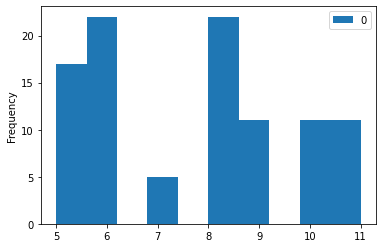

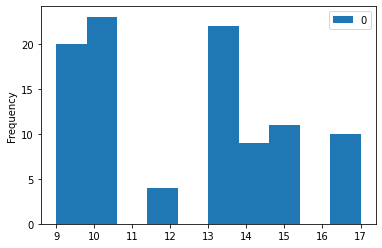

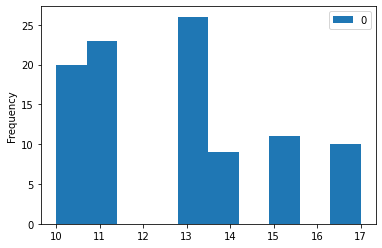

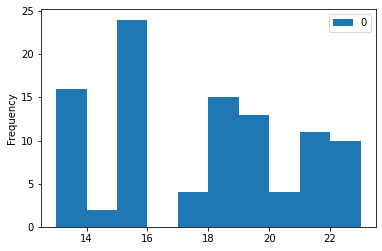

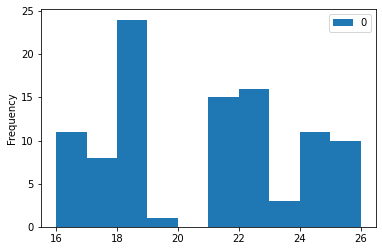

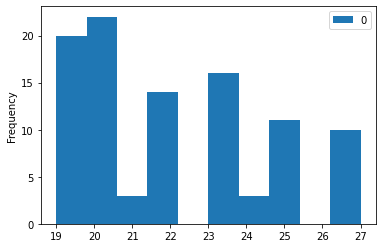

In [60]:
#! IMPORTANT PARAMETER
number_of_ie_to_take_in_account = 10

most_present_ie_random = df_ie.sort_values(by='Random MACs', ascending=False)[:number_of_ie_to_take_in_account].index.tolist()
most_present_ie_fixed = df_ie.sort_values(by='Fixed MACs', ascending=False)[:number_of_ie_to_take_in_account].index.tolist()

print(f"\n10 most present information elements in ramdom MACs probes: \n", most_present_ie_random)
print(f"\n10 most present information elements in fixed MACs probes: \n", most_present_ie_fixed)

del number_of_ie_to_take_in_account

df_ie

In [ ]:
print("Number of probes pre-cleaning: ", len(df))
print("Number of MACs pre-cleaning: ", len(df['mac'].unique()))
# Computing how many entries there are for each mac_address
df_temp = df[['mac','timestamp']].groupby('mac').count()
mac_to_remove = df_temp[df_temp['timestamp'].isin([1])].index

# Discarding mac_addresses where there is only one value
df = df[~df['mac'].isin(mac_to_remove)]
print("Number of probes post-cleaning: ", len(df))
print("Number of MACs post-cleaning: ", len(df['mac'].unique()))

del mac_to_remove, df_temp

In [ ]:
df_random = df[df.random == True]
df_random = df_random.drop(columns=['random'])

df_fixed = df[df.random == False]
df_fixed = df_fixed.drop(columns=['random'])

In [ ]:
df_sparse = dense_to_sparse_dataframe(df_random)
df_sparse = df_sparse[most_present_ie_random].reset_index().rename(columns={'index':'mac'})
df_probes = pd.merge(df_sparse, df_random, on='mac')
df_probes = df_probes.drop(columns=['id','len']).drop_duplicates(subset=['mac','seq'])

del df_sparse


In [ ]:
df_to_clusterize = df_probes[most_present_ie_random].drop_duplicates().astype('float').copy().fillna(-1)

X = StandardScaler().fit_transform(df_to_clusterize)
np.seterr(divide='ignore')
n_clusters_list = []
e = {}
for eps in range(1,100,1):
    eps = eps/100
    # Compute DBSCAN
    db = DBSCAN(eps=eps, min_samples=1).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    e[f'{n_clusters_}'] = eps
    n_clusters_list.append(n_clusters_)

pd.DataFrame(n_clusters_list).plot.hist()

try:
    most_present_cluster_number = mode(n_clusters_list)
except StatisticsError as e:
    clusters_occurrency = Counter(n_clusters_list)
    most_present_cluster_number = max(clusters_occurrency.items(), key=operator.itemgetter(1))[0]

eps = e[f'{most_present_cluster_number}']
print(f"Most present cluster number: {most_present_cluster_number} --> eps: {eps}")

##%% CLUSTERING USING THE EPS OBTAINED PREVIOUSLY

X = StandardScaler().fit_transform(df_to_clusterize)
np.seterr(divide='ignore')
# Compute DBSCAN
db = DBSCAN(eps=eps, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# ADDING THE DEVICE LABEL TO THE INITIAL DATAFRAME
df_to_clusterize['label_device'] = labels
df_to_clusterize.iloc[:,:-1] = df_to_clusterize.iloc[:,:-1].replace(-1,np.nan)
df_probes = pd.merge(df_probes, df_to_clusterize, how='left', on=most_present_ie_random)

del X, core_samples_mask, db, e, labels, n_clusters_, n_clusters_list, df_to_clusterize


In [ ]:
GT = 23
GT_fixed = 10
GT_random = GT - GT_fixed

print(f"Devices with fixed MAC: {GT_fixed}\n"
      f"Devices with random MAC: {most_present_cluster_number}\n"
      f"Total devices number obtained: {GT_fixed + most_present_cluster_number}\n"
      f"Real devices number: {GT}\n"
      f"Counting accuracy: {round(1-abs(((GT_fixed + most_present_cluster_number)-GT)/GT),2)}\n")
